In [2]:
# Jade Chongsathapornpong, June 2023
import os
import re

# import silx
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter

import rocklogparse as rlp

# may break in some versions of Jupyter; use inline instead if so
#%matplotlib nbagg  
%matplotlib inline

# Selecting Files to Plot
The ROCK beamline data extraction tool currently gives a deep directory structure. The following is to navigate and preprocess selected files in it; the files are already pre-normalized.

In [21]:
# Choose file paths (modify these)
elem='Zn'
root = os.path.join(r'..\Data\ROCK\XAS\WAM39B\WAM39B_Rampe_1', elem + '_Kedge')
temp_cal_file = r'../Data/ROCK/calibration_gas_blower_1mm.txt' # log file with temperature columns for calib
edges = {'Co': 7709, 'Cu': 8979, 'Ni': 8333, 'Zn': 9658}
# print(os.listdir(root))

In [4]:
# Temperature Calibration
sample_vs_setpt = np.array(rlp.read_column_log(temp_cal_file, indices=(1,3), skiprows=3)).transpose()
sample = sample_vs_setpt[0] # sample temperature, y-axis
setpoint = sample_vs_setpt[1] # control temperature, x-axis

def quadratic(x, a, b, c):
    return a*x*x + b*x + c

poptim, pcovar = curve_fit(quadratic, setpoint, sample)
print("Covariances\n", pcovar)
print(f"Fit: {poptim[0]} T^2 + {poptim[1]} T + {poptim[2]}")

# plt.scatter(setpoint, sample, label='data', color='blue')
# plt.plot(setpoint, quadratic(setpoint, poptim[0], poptim[1], poptim[2]), label='fit', color='orange')
# plt.xlabel("Setpoint (C)")
# plt.ylabel("Sample (C)")
# plt.legend()
# plt.show()

Covariances
 [[ 1.16888629e-12 -1.08020955e-09  7.45944282e-08]
 [-1.08020955e-09  1.06155040e-06 -9.05664686e-05]
 [ 7.45944282e-08 -9.05664686e-05  2.07220001e-02]]
Fit: -0.0001761292340057989 T^2 + 1.0543244247291368 T + 0.0033350713710040606


In [22]:
# PLEASE NOTE this logic may need to be modified for different folder structures.

# Selects files in a directory structured like WAM39B_Rampe_1/Zn_Kedge
target_files = []
for directory in os.listdir(root):
    if directory[-3:] != '120': 
        continue # we want the ones that are averages of 120 only
    # if we made it here, explore the directory
    path = os.path.join(root, directory, 'normalized')
    for file in os.listdir(path):
        # move on if it's not a file of interest
        if file[:7] != ('norm_' + elem) and file[:8] != 'norm_WAM':
            continue # we want to ignore pivot files, for example
        # otherwise add the whole path to target_files
        target_files.append(os.path.join(path, file))

In [ ]:
# To manually select normalized target files
#target_files = [
    #r"C:\Users\jade2\Dropbox (Personal)\CNRS_Internship\Data\ROCK\XAS\WAM39B\WAM39B_Rampe_1\Cu_Kedge\Cu_WAM39B_Rampe_1_035_av120\normalized\norm_Cu_WAM39B_Rampe_1_035_av120_00005.txt",
    #r"C:\Users\jade2\Dropbox (Personal)\CNRS_Internship\Data\ROCK\XAS\WAM39B\WAM39B_fin_palier_1\Cu_WAM39B_fin_palier_1_001_av1800\normalized\norm_Cu_WAM39B_fin_palier_1_001_av1800_00001.txt",
    #r"C:\Users\jade2\Dropbox (Personal)\CNRS_Internship\Data\ROCK\XAS\WAM39B\WAM39B_Rampe_2\Cu_Kedge\Cu_WAM39B_Rampe_2_020_av120\normalized\norm_Cu_WAM39B_Rampe_2_020_av120_00005.txt",
    #r"C:\Users\jade2\Dropbox (Personal)\CNRS_Internship\Data\ROCK\XAS\WAM39B\WAM39B_fin_palier_Zn_4\Cu_WAM39B_fin_palier_Zn_4_001_av1800\normalized\norm_Cu_WAM39B_fin_palier_Zn_4_001_av1800_00001.txt"
#]

# Reading file data

In [23]:
# Reads data from the files selected previously into a list called output_data 

hbar = 1.055e-34 # J * s
m = 9.1e-31 # kg
JeV = 1.602e-19 # J per eV

def E_to_k(E: np.ndarray, E_edge: float) -> np.ndarray:
    """Args:
        - E (array-like): energies (in eV)
        - E_edge (float): 
    Returns:
        - (array-like) wavenumbers for photoelectron (in 1/A)"""
    K = (E - E_edge) * JeV
    return (np.sqrt(2 * m * K) / hbar) * 1e-10
    
output_data = [] # one element per file consisting of file name, array of energies, array of signals
for file in target_files:
    temp = None
    with open(file) as f:
        for i, line in enumerate(f):
            if i == 6: # the temperature is on the 7th line
                temp = float(re.findall(r'\d+.\d+', line)[0])
                break
    # Read the columns into format: filename, calib. Temp., energy, wavenumber, XAS signal
    arr = np.genfromtxt(file).transpose() # 5 rows: shifted energy, normalized signal, reference signal, ref. deriv., I_0
    output_data.append((file, quadratic(temp, poptim[0], poptim[1], poptim[2]), arr[0], E_to_k(arr[0], edges[elem]), arr[1]))
                             
output_data.sort(key=lambda x: os.path.split(x[0])) # sort by file name alphabetical
# output_data.sort(key=lambda x: x[1]) # or sort by temperature

C:\Users\jade2\AppData\Local\Temp\ipykernel_6728\2255020140.py:16: RuntimeWarning: invalid value encountered in sqrt
  return (np.sqrt(2 * m * K) / hbar) * 1e-10


In [ ]:
# Check that we have the right files
print("# of Files:", len(output_data))
print("First 10:\n", [os.path.split(d[0])[-1] for d in output_data[:10]])
print("Last 10:\n", [os.path.split(d[0])[-1] for d in output_data[-10:]])

# Plots

### Absorption per Temperature

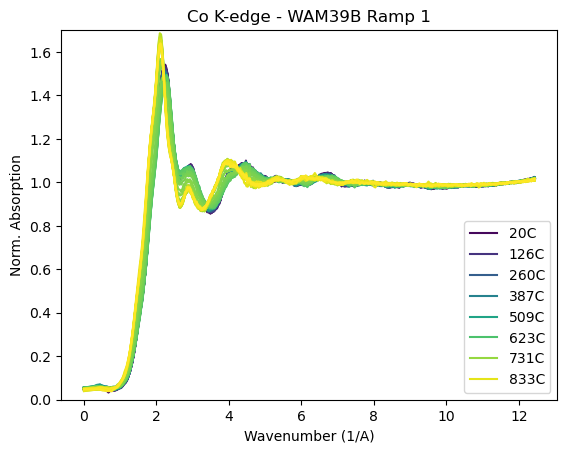

In [7]:
x_axis = 3  # 2 for energy, 3 for k
title = elem + ' K-edge - WAM39B Ramp 1'
T_min = 0
T_range = 870
time_per_file = 1 # minutes
stride = 2 # 1 = plot every spectrum, 2 = plot every other spectrum, etc.
label_stride = 10 # don't add a label to every single plot

y_min = 0.0
y_max = 1.7

filtered_data = list(filter(lambda entry: entry[1] > T_min and entry[1] < T_min + T_range, output_data))
plotted_data = []

colors = plt.cm.viridis([(entry[1] - T_min) / T_range for entry in filtered_data])
for i, entry in enumerate(filtered_data):
    if i % stride == 0:
        plt.plot(entry[x_axis], entry[4], label=f'{entry[1]:.0f}C' if i % (stride * label_stride) == 0 else None, color=colors[i])
        plotted_data.append(entry)

plt.title(title)
plt.xlabel(f'Energy (eV)' if x_axis == 2 else 'Wavenumber (1/A)')
plt.ylabel('Norm. Absorption')
plt.ylim((y_min, y_max))
plt.legend()
# plt.savefig(os.path.join('Output', title), dpi=300)
plt.show()

### Comparing individual spectra
This is for comparing, say, the end of a ramp to the end of the subsequent dwell, without the colormap used in the previous cell.

In [ ]:
x_axis = 3  # 2 for energy, 3 for k
title = elem + ' K-edge - WAM39B Ramp 1'

y_min = 0.0
y_max = 1.7

target_filenames = ['End Ramp 1', 'End Plateau 1', 'End Ramp 2', 'End Plateau 2']

for i, entry in enumerate(filtered_data):
        plt.plot(entry[x_axis], entry[4], label=f'{target_filenames[i]}, {entry[1]:.0f}C')

plt.title(title)
plt.xlabel(f'Energy (eV)' if x_axis == 2 else 'Wavenumber (1/A)')
plt.ylabel('Norm. Absorption')
plt.ylim((y_min, y_max))
plt.legend()
# plt.savefig(os.path.join('Output', title), dpi=300)
plt.show()

### Change over Time (Differential Spectra)

In [11]:
abs_diff_buffer = [] # RUN THIS TO RESET THE BUFFER OF DIFFERENTIAL SPECTRA

In [9]:
def total_abs_diffs(spectra, wavenumbers=None, wavenumber_window=(2.5, 8)):
    """Args:
        - spectra (2d array-like): list of normalized absorption spectra, in order
        - wavenumbers (array-like): array of the wavenumbers corresponding to points in spectra
        - wavenumber_window (tuple): min, max wavenumber to be accounted in sums
    Returns:
        - (list) total absolute differences between the normalized spectra
            from one to the next within wavenumber_window"""
    ADs = []
    if wavenumbers is not None:
        mask = np.logical_and(wavenumbers > wavenumber_window[0], wavenumbers < wavenumber_window[1])
    else:
        mask = 1
    for i in range(len(spectra) - 1):
        diffs = mask * (spectra[i + 1] - spectra[i])
        ADs.append(np.sum(np.abs(diffs)))
    return ADs

def noise_reduction(spectra, sg_window_E=11, sg_window_t=9):
    """Args:
        - spectra (2d array)
        - sg_window_E (int): Length of energy (axis 1) window for Savitzky-Golay filter
        - sg_window_t (int): Length of time (axis 0) window for Savitzky-Golay filter
    Returns:
        - 2D-filtered (see fastosh manual 'Two-D filtering')"""
    X = np.array(spectra)
    X1 = savgol_filter(X, window_length=sg_window_t, polyorder=3, axis=0)
    return savgol_filter(X1, window_length=sg_window_E, polyorder=3, axis=1)

In [24]:
times = [i * time_per_file for i in range(len(output_data) - 1)]
spectra = np.array([entry[4] for entry in output_data])
wavenumbers = output_data[0][3]
temperatures = [entry[1] for entry in output_data]

# Uncomment if using only the spectra plotted in "Absorption per Temperature"
# times = [i * stride * time_per_file for i in range(len(plotted_data) - 1)]
# spectra = np.array([entry[4] for entry in plotted_data])
# wavenumbers = output_data[0][3]
# temperatures = [entry[1] for entry in plotted_data]

filtered_spectra = noise_reduction(spectra, 16, 16)
# filtered_spectra = spectra # for no noise reduction

window = (2.18, 8.)
abs_diffs = total_abs_diffs(filtered_spectra, wavenumbers, window)

abs_diff_buffer.append((abs_diffs, elem))

In [ ]:
title2 = elem + " K-edge - WAM39B Ramp 1 - Absolute Differences"

fig, (ax1, ax2) = plt.subplots(2,1)
ax1.plot(times, abs_diffs, color='b')
ax1.set(xticklabels=[])
ax1.set_ylim(0,)
ax1.set_title(title2)
ax1.set_ylabel("Abs. Norm. Difference")
ax2.plot(times, temperatures[1:], color='orange')
ax2.set_xlabel("Time (min)")
ax2.set_ylabel("Temperature (C)")

t_onset = 90
T_onset = 575
ax1.axvline(t_onset, color='k', lw=1)
ax2.axvline(t_onset, color='k', lw=1)
ax2.axhline(T_onset, color='k', lw=1, ls='--')

# plt.savefig(os.path.join('Output', title2), dpi=300)
plt.show()

## Change over time - plotting multiple
To do this, run the above multiple times before running this cell.

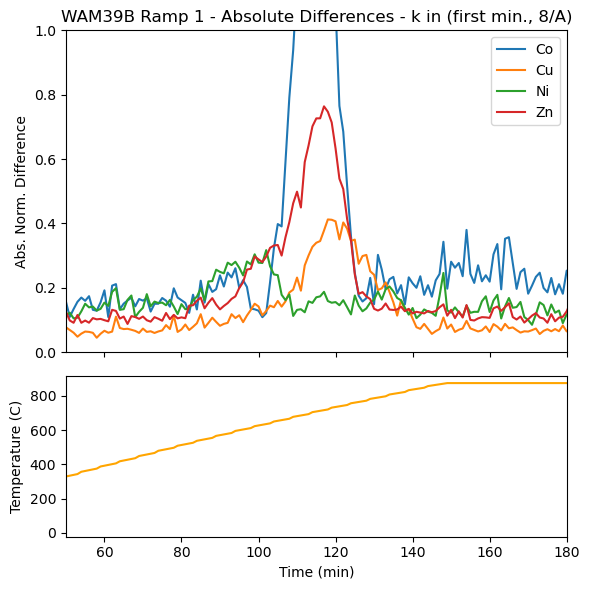

In [27]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(6,6), gridspec_kw={'height_ratios': [2,1]})
for diff in abs_diff_buffer:
    # ax1.scatter(times, diff[0], s=5, label=diff[1])
    ax1.plot(times, diff[0], label=diff[1])
ax1.set(xticklabels=[])
ax1.set_title('WAM39B Ramp 1 - Absolute Differences - k in (first min., 8/A)')
ax1.set_ylabel("Abs. Norm. Difference")
ax2.plot(times, temperatures[1:], color='orange')
ax2.set_xlabel("Time (min)")
ax2.set_ylabel("Temperature (C)")

ax1.set_ylim(0,1)
ax1.set_xlim(50, 180)
ax2.set_xlim(50, 180)

ax1.legend()
plt.tight_layout()
# plt.savefig(os.path.join('Output', 'WAM39B Ramp 1 All FirstMin Zoom'), dpi=300)
plt.show()